# US State COVID Data Analysis - Deaths
============================================================

The purpose of this notebook is to examine various factors as they relate to the reported COVID death rates among the US states. The 'death rate' is measured as total reported COVID deaths per 100,000 state inhabitants, per the 2019 census data.

## Assumptions
--------------------

1. We are assuming that the reported COVID death data is accurate (we may want to switch sources, or even aggregate them, if we find the current source to be lacking).
2. We are not attempting to control for the actuality of certain policies, just their existence (i.e. we are only examining that a statewide 'mask order' is in place, not whether - and to what degree - the population is actually adhering to it).


## Factors Examined
--------------------------

The factors we are examining are as follows:

- [x] Population Density
- [x] Average age of population
- [x] 'Over 60' population (percentage and 'raw')
- [x] Lockdowns (state-wide mandate)
- [x] Mask mandates

### Population Density
------------------------

Examine the relationship, if any, between population density and death rate.

Population density data is available via the [US Census's API](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.html).

### Average Age
-----------------

Examine the relationship, if any, between average age in a state and death rate.

Age data is available via the [US Census's API](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.html).

### 'Over 60' Population
-------------------------

Examine the relationship, if any, between a state's 'over 60' population and death rate.

Age data is available via the [US Census's API](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.html).

### Lockdowns
---------------

Examine the relationship, if any, between a state's lockdown policies and death rate.

This is a difficult factor to analyze. States are currently scattered among several different
(and differently defined) 'phases' or reopening. For now, we will simply using the below sources
to estimate the total number of days of 'complete' lockdown per state (i.e., an official 'stay-at-home' order/direction/advisory from the Governor, without any phased reopening).

Sources:
- https://www.timeanddate.com/holidays/us/lockdown-day-1
- https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html

Factors to Analyze:
- [x] Total number of days in lockdown
- [x] Lockdown vs no lockdown
- [x] First day of lockdown (on a relative scale, with the earliest date being 0)

### Mask Mandates
--------------------

Examine the relationship, if any, between a state's mask mandate policies and death rate.

Sources:
- https://www.cnn.com/2020/06/19/us/states-face-mask-coronavirus-trnd/index.html

Factors to Analyze:
- [x] Total number of days in mask order
- [x] Mask order vs no mask order
- [x] First day of mask order (on a relative scale, with the earliest date being 0)

### Mask Compliance Rate
---------------------------

Examine the relationship, if any, between a state's mask compliance rate and death rate.

Factors to analyze:
- [x] Average mask non-compliance rate over time period (as estimate for a state's non-compliance during the mask order time)

Sources:
https://delphi.cmu.edu/covidcast/?sensor=chng-smoothed_adj_outpatient_cli&level=county&date=20201215&signalType=value&encoding=color&mode=export&region=42003

### Mobility Data (proxy for 'lockdown compliance')
-----------------------------------------------------

Factors to analyze:
- [x] Away for 3-6 hours (average over all time available)
- [x] Away for 6+ hours (average over all time available)
- [x] Bar visits (average over all time available)
- [x] Restaurant visits (average over all time available)
- [x] Not social distancing (spending time with others outside hjome)

Sources:
https://delphi.cmu.edu/covidcast/?sensor=chng-smoothed_adj_outpatient_cli&level=county&date=20201215&signalType=value&encoding=color&mode=export&region=42003

### Health
-----------------------------------

Examine the relationship, if any, between the health of a state's citizens and the death rate

Factors to analyze:
- [x] Type 2 Diabetes Rate
- [x] Obesity Rate
- [x] Heart Disease Death Rate
- [x] COPD Rate
- [x] 'Healthiness Rank'

### Overall
------------

Control for all non-NPI (non-pharmeceutical intervention) factors.

Sources:
https://www.cdc.gov/obesity/data/prevalence-maps.html
https://stateofchildhoodobesity.org/diabetes/
https://www.cdc.gov/nchs/pressroom/sosmap/heart_disease_mortality/heart_disease.htm
https://www.statista.com/statistics/761348/copd-prevalence-us-by-state/
https://www.americashealthrankings.org/
https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html

In [182]:
from datetime import date, datetime
import numpy as np
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import covidcast
import pingouin as pg
import scipy

%matplotlib inline

In [183]:
## Data collection date (for COVID data)
%%capture
data_date = 20210310
## Utility map of state names to codes
state_code_map = {
    'Alaska': 'AK',
    'Alabama': 'AL',
    'Arkansas': 'AR',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Iowa': 'IA',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Massachusetts': 'MA',
    'Maryland': 'MD',
    'Maine': 'ME',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Missouri': 'MO',
    'Northern Mariana Islands': 'MP',
    'Mississippi': 'MS',
    'Montana': 'MT',
    'National': 'NA',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Nebraska': 'NE',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'Nevada': 'NV',
    'New York': 'NY',
    'New York City': 'NY', # Done to ensure NYC CDC data included with NY
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Virginia': 'VA',
    'Virgin Islands': 'VI',
    'Vermont': 'VT',
    'Washington': 'WA',
    'Wisconsin': 'WI',
    'West Virginia': 'WV',
    'Wyoming': 'WY'
}

UsageError: Line magic function `%%capture` not found.


In [184]:
# Lockdown start date
first_lockdown_date = {
    'CA': datetime(2020, 3, 19),
    'NV': datetime(2020, 3, 20),
    'IL': datetime(2020, 3, 21),
    'NJ': datetime(2020, 3, 21),
    'LA': datetime(2020, 3, 22),
    'NY': datetime(2020, 3, 22),
    'CT': datetime(2020, 3, 23),
    'HI': datetime(2020, 3, 23),
    'MD': datetime(2020, 3, 23),
    'OH': datetime(2020, 3, 23),
    'OR': datetime(2020, 3, 23),
    'MA': datetime(2020, 3, 23),
    'NM': datetime(2020, 3, 23),
    'DE': datetime(2020, 3, 24),
    'MI': datetime(2020, 3, 24),
    'WA': datetime(2020, 3, 24),
    'WV': datetime(2020, 3, 24),
    'ID': datetime(2020, 3, 25),
    'IN': datetime(2020, 3, 25),
    'WI': datetime(2020, 3, 25),
    'VT': datetime(2020, 3, 25),
    'CO': datetime(2020, 3, 26),
    'KY': datetime(2020, 3, 26),
    'MN': datetime(2020, 3, 27),
    'NH': datetime(2020, 3, 27),
    'UT': datetime(2020, 3, 27),
    'AK': datetime(2020, 3, 28),
    'RI': datetime(2020, 3, 28),
    'MT': datetime(2020, 3, 28),
    'KS': datetime(2020, 3, 29),
    'NC': datetime(2020, 3, 30),
    'VA': datetime(2020, 3, 30),
    'AZ': datetime(2020, 3, 31),
    'TX': datetime(2020, 3, 31),
    'DC': datetime(2020, 4, 1),
    'ME': datetime(2020, 4, 2),
    'OK': datetime(2020, 4, 2),
    'PA': datetime(2020, 4, 2),
    'TN': datetime(2020, 4, 2),
    'FL': datetime(2020, 4, 3),
    'GA': datetime(2020, 4, 3),
    'MS': datetime(2020, 4, 3),
    'AL': datetime(2020, 4, 4),
    'MO': datetime(2020, 4, 6),
    'SC': datetime(2020, 4, 7),
}
# Lockdown 'end date' (or, beginning of 'phased' reopening)
lockdown_end_date = {
    'CA': datetime(2020, 5, 25),
    'NV': datetime(2020, 5, 9),
    'IL': datetime(2020, 5, 29),
    'NJ': datetime(2020, 6, 9),
    'LA': datetime(2020, 5, 15),
    'NY': datetime(2020, 5, 29),
    'CT': datetime(2020, 5, 20),
    'HI': datetime(2020, 5, 7),
    'MD': datetime(2020, 5, 15),
    'OH': datetime(2020, 5, 12),
    'OR': datetime(2020, 5, 15),
    'MA': datetime(2020, 5, 18),
    'NM': datetime(2020, 5, 16),
    'DE': datetime(2020, 6, 1),
    'MI': datetime(2020, 6, 1),
    'WA': datetime(2020, 5, 26),
    'WV': datetime(2020, 5, 4),
    'ID': datetime(2020, 5, 1),
    'IN': datetime(2020, 5, 4),
    'WI': datetime(2020, 5, 13),
    'VT': datetime(2020, 5, 15),
    'CO': datetime(2020, 4, 27),
    'KY': datetime(2020, 5, 20),
    'MN': datetime(2020, 5, 18),
    'NH': datetime(2020, 5, 11),
    'UT': datetime(2020, 5, 1),
    'AK': datetime(2020, 4, 24),
    'RI': datetime(2020, 5, 9),
    'MT': datetime(2020, 4, 26),
    'KS': datetime(2020, 5, 4),
    'NC': datetime(2020, 5, 8),
    'VA': datetime(2020, 5, 15),
    'AZ': datetime(2020, 5, 8),
    'TX': datetime(2020, 5, 1),
    'DC': datetime(2020, 5, 29),
    'ME': datetime(2020, 5, 1),
    'OK': datetime(2020, 4, 24),
    'PA': datetime(2020, 5, 15),
    'TN': datetime(2020, 4, 27),
    'FL': datetime(2020, 5, 4),
    'GA': datetime(2020, 4, 24),
    'MS': datetime(2020, 4, 27),
    'AL': datetime(2020, 4, 30),
    'MO': datetime(2020, 5, 4),
    'SC': datetime(2020, 4, 20),
}
# Total days in 'complete' lockdown
statewide_lockdown_days = {
    'SD': 0,
    'AR': 0,
    'IA': 0,
    'ND': 0,
    'NE': 0,
    'WY': 0
}
# Calculate total days in lockdown for states that did lockdown
for state, code in state_code_map.items():
    if code not in first_lockdown_date.keys():
        continue
    delta = lockdown_end_date[code] - first_lockdown_date[code]
    statewide_lockdown_days[code] = delta.days
# First date of any lockdown
first_lockdown_state_date = datetime.now()
first_lockdown_state = ''
for state, start_date in first_lockdown_date.items():
    if start_date < first_lockdown_state_date:
        first_lockdown_state_date = start_date
        first_lockdown_state = state
print('date of first lockdown: {} in {}'.format(first_lockdown_state_date, first_lockdown_state))

date of first lockdown: 2020-03-19 00:00:00 in CA


In [185]:
# Mask mandate start date (for states with mandates)
mask_mandate_start_date = {
    'AL': datetime(2020, 7, 15),
    'AR': datetime(2020, 7, 20),
    'CA': datetime(2020, 6, 18),
    'CO': datetime(2020, 7, 17),
    'CT': datetime(2020, 4, 20),
    'DE': datetime(2020, 4, 28),
    'DC': datetime(2020, 5, 16),
    'HI': datetime(2020, 4, 20),
    'IL': datetime(2020, 5, 1),
    'IN': datetime(2020, 7, 27),
    'KS': datetime(2020, 7, 3),
    'KY': datetime(2020, 5, 11),
    'LA': datetime(2020, 7, 13),
    'ME': datetime(2020, 5, 1),
    'MD': datetime(2020, 4, 18),
    'MA': datetime(2020, 5, 6),
    'MI': datetime(2020, 6, 18),
    'MT': datetime(2020, 7, 16),
    'NV': datetime(2020, 6, 24),
    'NH': datetime(2020, 8, 11),
    'NJ': datetime(2020, 4, 8),
    'NM': datetime(2020, 5, 16),
    'NY': datetime(2020, 4, 17),
    'NC': datetime(2020, 6, 26),
    'OH': datetime(2020, 7, 23),
    'OR': datetime(2020, 7, 1),
    'PA': datetime(2020, 4, 19),
    'RI': datetime(2020, 5, 8),
    'TX': datetime(2020, 7, 3),
    'VT': datetime(2020, 8, 1),
    'VA': datetime(2020, 5, 29),
    'WA': datetime(2020, 6, 26),
    'WV': datetime(2020, 7, 6),
    'WI': datetime(2020, 8, 1),
}
# Mask order end dates (so far, no mask orders have been ended)
mask_mandate_end_date = {}
# First date of any mask order
first_mask_order_date = datetime.now()
first_mask_state = ''
for state, start_date in mask_mandate_start_date.items():
    if start_date < first_mask_order_date:
        first_mask_order_date = start_date
        first_mask_state = state
print('date of first mask order: {} in {}'.format(first_mask_order_date, first_mask_state))

date of first mask order: 2020-04-08 00:00:00 in NJ


In [186]:
# Get the total mortality data by state from the CDC
params = {'$limit': 1000000}
res = requests.get("https://data.cdc.gov/resource/muzy-jte6.csv", params).content
deaths_csv = io.StringIO(res.decode('utf-8'))
with open('cdc_state_death_data.csv', 'w') as f:
    f.write(deaths_csv.getvalue())
cdc_total_death_state_data = pd.read_csv(deaths_csv)


In [187]:
cdc_total_death_state_data['state'] = cdc_total_death_state_data[cdc_total_death_state_data['jurisdiction_of_occurrence'] != 'United States'].apply(lambda r: state_code_map[r['jurisdiction_of_occurrence']], axis=1)

In [188]:
cdc_total_deaths_yearly_sum = cdc_total_death_state_data.groupby(['state', 'mmwryear']).sum()

In [190]:
# Get data on mask usage by state
## First date available for state data is 09/08/2020
mask_non_compliance_by_state = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                        date(2020, 9, 8), date(2021, 3, 10),
                        "state");
mask_non_compliance_by_state['value'] = 100 - mask_non_compliance_by_state['value']
with open('mask_non_compliance_state.csv', 'w') as f:
    mask_non_compliance_by_state.to_csv(f)

***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20210222 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20210223 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20210224 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20210225 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 202

In [191]:
# Get Mobility data
## Away for 6+ hours
away_6 = covidcast.signal("safegraph", "full_time_work_prop_7dav",
                        date(2020, 10, 1), date(2021, 3, 10),
                        "state");


In [192]:
with open('away_6_safegraph_state.csv', 'w') as f:
    away_6.to_csv(f)

In [193]:
## Away for 3-6 hours
away_3_6 = covidcast.signal("safegraph", "part_time_work_prop_7dav",
                        date(2020, 10, 1), date(2021, 3, 10),
                        "state");
with open('away_3_6_safegraph_state.csv', 'w') as f:
    away_3_6.to_csv(f)

In [194]:
## Daily bar visits
away_bar = covidcast.signal("safegraph", "bars_visit_prop",
                        date(2020, 10, 1), date(2021, 3, 10),
                        "state");
with open('away_bar_safegraph_state.csv', 'w') as f:
    away_bar.to_csv(f)

***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph bars_visit_prop data found on 20201214 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph bars_visit_prop data found on 20201215 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph bars_visit_prop data found on 20201216 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph bars_visit_prop data found on 20201217 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph bars_visit_prop data found on 20201218 for geography 'state'
  

In [195]:
## Daily restaurant visits
away_restaurant = covidcast.signal("safegraph", "restaurants_visit_prop",
                        date(2020, 10, 1), date(2021, 3, 10),
                        "state");
with open('away_restaurant_safegraph_state.csv', 'w') as f:
    away_restaurant.to_csv(f)

***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph restaurants_visit_prop data found on 20201214 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph restaurants_visit_prop data found on 20201215 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph restaurants_visit_prop data found on 20201216 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph restaurants_visit_prop data found on 20201217 for geography 'state'
  NoDataWarning)
***/othercoding/covid-data-analysis/venv/lib/python3.7/site-packages/covidcast/covidcast.py:419: NoDataWarning: No safegraph restaurants_visit_prop data found o

In [196]:
# Non-social distancing
spent_time_with_others = covidcast.signal("fb-survey", "smoothed_spent_time_1d",
                        date(2020, 10, 1), date(2021, 3, 10),
                        "state");
with open('spent_time_with_others_safegraph_state.csv', 'w') as f:
    spent_time_with_others.to_csv(f)


In [197]:
type_2_diabetes_rate = {
    'AL': 14.0,
    'AK': 7.3,
    'AR': 13.6,
    'AZ': 10.9,
    'CA': 10.1,
    'CO': 7.0,
    'CT': 9.6,
    'DE': 8.7,
    'DC': 12.8,
    'FL': 11.7,
    'GA': 12.0,
    'HI': 10.5,
    'IA': 10.3,
    'ID': 10.3,
    'IL': 11.3,
    'IN': 12.4,
    'KS': 10.8,
    'KY': 13.3,
    'LA': 12.6,
    'ME': 10.6,
    'MD': 11.0,
    'MA': 8.4,
    'MI': 11.1,
    'MN': 8.8,
    'MO': 10.3,
    'MS': 14.8,
    'MT': 7.6,
    'ND': 8.9,
    'NE': 10.2,
    'NH': 9.2,
    'NJ': 10.8,
    'NM': 12.3,
    'NV': 10.9,
    'NY': 10.5,
    'NC': 11.8,
    'OK': 12.2,
    'OH': 12.0,
    'OR': 8.6,
    'PA': 10.8,
    'RI': 10.4,
    'SC': 13.4,
    'SD': 10.6,
    'TN': 13.8,
    'TX': 12.2,
    'UT': 8.0,
    'VT': 8.7,
    'VA': 10.9,
    'WA': 9.4,
    'WV': 15.7,
    'WI': 8.7,
    'WY': 7.8
}

In [198]:
obesity_rates = {
    'AL': 36.1,
    'AK': 30.5,
    'AR': 37.4,
    'AZ': 31.4,
    'CA': 26.2,
    'CO': 23.8,
    'CT': 29.1,
    'DE': 34.4,
    'DC': 23.8,
    'FL': 27,
    'GA': 33.1,
    'HI': 25,
    'IA': 33.9,
    'ID': 29.5,
    'IL': 31.6,
    'IN': 35.3,
    'KS': 35.2,
    'KY': 36.5,
    'LA': 35.9,
    'ME': 31.7,
    'MD': 32.3,
    'MA': 25.2,
    'MI': 36,
    'MN': 30.1,
    'MO': 34.8,
    'MS': 40.8,
    'MT': 28.3,
    'NC': 34,
    'ND': 34.8,
    'NE': 34.1,
    'NH': 31.8,
    'NJ': 27.7,
    'NM': 31.7,
    'NV': 30.6,
    'NY': 27.1,
    'OK': 36.8,
    'OH': 34.8,
    'OR': 29,
    'PA': 33.2,
    'RI': 30,
    'SC': 35.4,
    'SD': 33,
    'TN': 36.5,
    'TX': 34,
    'UT': 29.2,
    'VT': 26.6,
    'VA': 31.9,
    'WA': 28.3,
    'WV': 39.7,
    'WI': 34.2,
    'WY': 29.7
}

In [199]:
heart_disease_death_rates = {
    'AL': 224.7,
    'AK': 129.7,
    'AR': 217.4,
    'AZ': 136.4,
    'CA': 139.7,
    'CO': 124.3,
    'CT': 142.1,
    'DE': 159.1,
    'DC': np.nan,
    'FL': 143.1,
    'GA': 175.8,
    'HI': 125.6,
    'IA': 165.1,
    'ID': 157.9,
    'IL': 163.9,
    'IN': 180.7,
    'KS': 158.9,
    'KY': 198.3,
    'LA': 212.2,
    'ME': 147,
    'MD': 161.9,
    'MA': 131.5,
    'MI': 195,
    'MN': 119,
    'MO': 188.4,
    'MS': 222.1,
    'MT': 163.2,
    'NC': 155.5,
    'ND': 140,
    'NE': 145.7,
    'NH': 151,
    'NJ': 163,
    'NM': 148.2,
    'NV': 190.7,
    'NY': 171.9,
    'OK': 228.5,
    'OH': 191.1,
    'OR': 128.4,
    'PA': 176.1,
    'RI': 158.9,
    'SC': 167,
    'SD': 156.3,
    'TN': 202.4,
    'TX': 170,
    'UT': 146.4,
    'VT': 150.5,
    'VA': 147.9,
    'WA': 135.4,
    'WV': 196.4,
    'WI': 157.8,
    'WY': 152.7
}

In [200]:
copd_rates = {
    'AL': 10.1,
    'AK': 6.3,
    'AR': 9.3,
    'AZ': 5.9,
    'CA': 4.4,
    'CO': 4.2,
    'CT': 5.3,
    'DE': 7.3,
    'DC': 5.8,
    'FL': 7.1,
    'GA': 6.8,
    'HI': 3.4,
    'IA': 5.9,
    'ID': 4.7,
    'IL': 6.4,
    'IN': 8,
    'KS': 6.2,
    'KY': 11.3,
    'LA': 8.4,
    'ME': 6.5,
    'MD': 5.4,
    'MA': 5,
    'MI': 8,
    'MN': 4,
    'MO': 7.9,
    'MS': 7.5,
    'MT': 5.7,
    'NC': 7.3,
    'ND': 4.8,
    'NE': 5.3,
    'NH': 6,
    'NJ': 5.8,
    'NM': 5.6,
    'NV': 6.5,
    'NY': 5,
    'OK': 8.1,
    'OH': 7.6,
    'OR': 4.9,
    'PA': 5.9,
    'RI': 7,
    'SC': 7.2,
    'SD': 4.4,
    'TN': 8.9,
    'TX': 4.8,
    'UT': 4.1,
    'VT': 5.7,
    'VA': 6.6,
    'WA': 5.4,
    'WV': 13.8,
    'WI': 4.7,
    'WY': 6.1
}

In [201]:
health_rank = {
    'AL': 47,
    'AK': 27,
    'AR': 48,
    'AZ': 31,
    'CA': 12,
    'CO': 10,
    'CT': 4,
    'DE': 30,
    'FL': 33,
    'GA': 40,
    'HI': 3,
    'IA': 20,
    'ID': 16,
    'IL': 26,
    'IN': 41,
    'KS': 29,
    'KY': 43,
    'LA': 49,
    'ME': 21,
    'MD': 18,
    'MA': 2,
    'MI': 32,
    'MN': 7,
    'MO': 39,
    'MS': 50,
    'MT': 24,
    'NC': 36,
    'ND': 14,
    'NE': 17,
    'NH': 6,
    'NJ': 8,
    'NM': 37,
    'NV': 35,
    'NY': 11,
    'OK': 46,
    'OH': 38,
    'OR': 22,
    'PA': 28,
    'RI': 13,
    'SC': 42,
    'SD': 25,
    'TN': 44,
    'TX': 34,
    'UT': 5,
    'VT': 1,
    'VA': 15,
    'WA': 9,
    'WV': 45,
    'WI': 23,
    'WY': 19
}

In [202]:
# Fetch state data from the COVID tracking API
state_data_url="https://api.covidtracking.com/v1/states/daily.csv"
res = requests.get(state_data_url).content
current_state_data = pd.read_csv(io.StringIO(res.decode('utf-8')))
with open('covidtracking_state_data.csv', 'w') as f:
    current_state_data.to_csv(f)

In [203]:
# Only get death data and total test results for each state
deaths_by_state = current_state_data[current_state_data['date'] == data_date][['state', 'death', 'totalTestResults']]
deaths_by_state = deaths_by_state.set_index('state')

In [204]:
from json import dump
# Fetch state population data from the US Census API
state_population_data = requests.get("http://api.census.gov/data/2019/pep/population?get=DENSITY,POP,NAME&for=state:*").json()
with open('state_population_data.json', 'w') as f:
    dump(state_population_data, f)


In [205]:
# Add population data to each state's row
deaths_by_state['population'] = np.nan
deaths_by_state['population_density'] = np.nan
deaths_by_state['state_id'] = ''
# Add population and population density
for data in state_population_data[1:]:
    # Get state code
    state_code = state_code_map[data[2]]
    deaths_by_state.at[state_code, 'population'] = data[1]
    deaths_by_state.at[state_code, 'population_density'] = data[0]
    deaths_by_state.at[state_code, 'state_id'] = data[3]
#Calculate deaths per 100k
deaths_by_state['deaths_per_100k'] = deaths_by_state['death']/(deaths_by_state['population']/100000)
#Calculate total all-cause deaths per 100k
#deaths_by_state['all_cause_deaths_2019_per_100k'] = cdc_total_deaths_yearly_sum[cdc_total_deaths_yearly_sum.index.get_level_values('mmwryear') == 2019].groupby('state').sum()['all_cause']/(deaths_by_state['population']/100000)
deaths_by_state['all_cause_deaths_2020_per_100k'] = cdc_total_deaths_yearly_sum[cdc_total_deaths_yearly_sum.index.get_level_values('mmwryear') >= 2020].groupby('state').sum()['all_cause']/(deaths_by_state['population']/100000)
#Non-covid deaths per 100k
deaths_by_state['non_covid_deaths_2020_per_100k'] = (cdc_total_deaths_yearly_sum[cdc_total_deaths_yearly_sum.index.get_level_values('mmwryear') >= 2020].groupby('state').sum()['all_cause'] - deaths_by_state['death'])/(deaths_by_state['population']/100000)
#deaths_by_state['all_cause_deaths_increase_per_100k'] = deaths_by_state['all_cause_deaths_2020_per_100k'] - deaths_by_state['all_cause_deaths_2019_per_100k']
#Calculate test per 100k
deaths_by_state['tests_per_100k'] = deaths_by_state['totalTestResults']/(deaths_by_state['population']/100000)

In [206]:
# Total COVID deaths 2020
total_deaths_2020 = cdc_total_death_state_data[(cdc_total_death_state_data['jurisdiction_of_occurrence'] == 'United States') & (cdc_total_death_state_data['mmwryear'] == 2020)]['all_cause'].sum()
total_deaths_2019 = 2854838 # https://www.cdc.gov/nchs/fastats/deaths.htm
total_covid_deaths_2020 = current_state_data[current_state_data['date'] == 20201231].set_index('state')['death'].sum()
total_non_covid_deaths_2020 = total_deaths_2020 - total_covid_deaths_2020
total_deaths_increase_from_2019 = total_deaths_2020 - total_deaths_2019
## Increase due to COVID
total_deaths_increase_covid_pct = (total_covid_deaths_2020 / total_deaths_increase_from_2019)
## Increase not due to COVID
total_deaths_increase_non_covid_pct = ((total_deaths_increase_from_2019 - total_covid_deaths_2020) / total_deaths_increase_from_2019)
total_deaths_increase_non_covid_pct


0.3943717183341725

In [207]:
# Create new DF for all mobility data
mobility_data_by_state = away_6.copy().set_index(['time_value','geo_value']).rename(columns={'value': 'away_6_plus'})
## Fraction of people away for 6+ hours a day
mobility_data_by_state = mobility_data_by_state.groupby(['geo_value']).mean()['away_6_plus'].to_frame()
## Fraction of people away for 3-6 hours a day
mobility_data_by_state = mobility_data_by_state.join(away_3_6.set_index(['time_value','geo_value']).rename(columns={'value': 'away_3_to_6'}).groupby(['geo_value']).mean()['away_3_to_6'].to_frame(), on=['geo_value'])
## Number of bar visits per day per 100k
#mobility_data_by_state['daily_bar_visits_per_100k'] = away_bar.set_index(['time_value','geo_value']).fillna(np.nan).groupby(['geo_value']).mean()['value'].values
mobility_data_by_state = mobility_data_by_state.join(away_bar.set_index(['time_value','geo_value']).rename(columns={'value': 'daily_bar_visits_per_100k'}).groupby(['geo_value']).mean()['daily_bar_visits_per_100k'].to_frame(), on=['geo_value'])
## Number of restaurant visits per day per 100k
mobility_data_by_state = mobility_data_by_state.join(away_restaurant.set_index(['time_value','geo_value']).rename(columns={'value': 'daily_restaurant_visits_per_100k'}).groupby(['geo_value']).mean()['daily_restaurant_visits_per_100k'].to_frame(), on=['geo_value'])
## General social distancing (spending time with others)
mobility_data_by_state = mobility_data_by_state.join(spent_time_with_others.set_index(['time_value','geo_value']).rename(columns={'value': 'spending_time_with_others_outside_home'}).groupby(['geo_value']).mean()['spending_time_with_others_outside_home'].to_frame(), on=['geo_value'])
## Capitalize state index
mobility_data_by_state.index = mobility_data_by_state.index.str.upper()
## Deaths per 100k
mobility_data_by_state['deaths_per_100k'] = deaths_by_state['deaths_per_100k']
## All cause deaths per 100k (2020)
mobility_data_by_state['all_cause_deaths_2020_per_100k'] = deaths_by_state['all_cause_deaths_2020_per_100k']
mobility_data_by_state['non_covid_deaths_2020_per_100k'] = deaths_by_state['non_covid_deaths_2020_per_100k']


<AxesSubplot:>

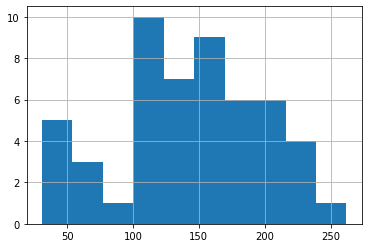

In [208]:
# Distribution of deaths_per_100k
deaths_by_state['deaths_per_100k'].hist()

<AxesSubplot:>

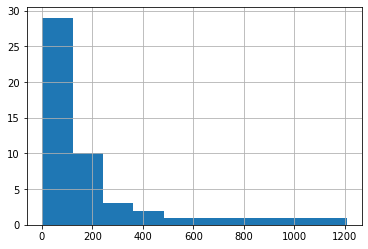

In [209]:
# Distribution of population density
### Exclude DC in chart because it throws the x axis off and makes it hard to read
deaths_by_state['population_density'].drop('DC').hist()

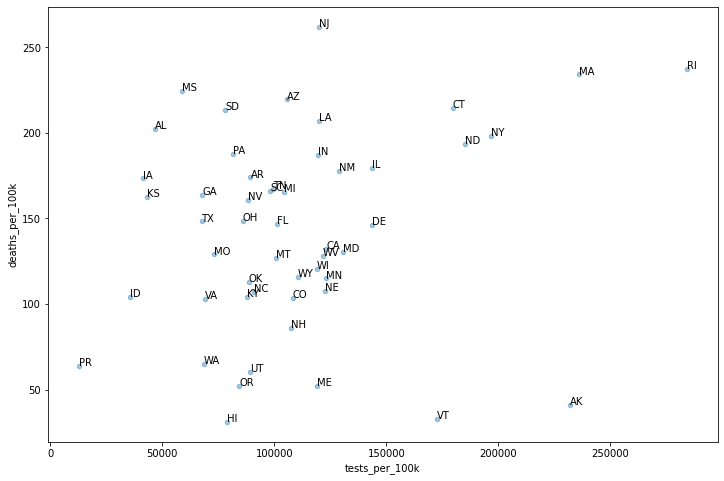

In [210]:
ax = deaths_by_state.dropna(subset=['tests_per_100k','deaths_per_100k']).drop('DC').plot(alpha=0.4,figsize=(12,8),x='tests_per_100k',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state.dropna(subset=['tests_per_100k','deaths_per_100k']).drop('DC').iterrows():
    ax.text(row['tests_per_100k'], row['deaths_per_100k'], str(index))

In [211]:
deaths_by_state['deaths_per_100k'].corr(deaths_by_state['tests_per_100k'])
# Try pearson correlation
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['tests_per_100k'], method="pearson")
print("Correlation coefficient between tests per 100k and deaths per 100k (Method:Pearson)")
print(round(corr_value,4));

# Try spearman, data appears potentially monotonic
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['tests_per_100k'], method="spearman");
print("Correlation coefficient between tests per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between tests per 100k and deaths per 100k (Method:Pearson)
0.2126
Correlation coefficient between tests per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)
0.176


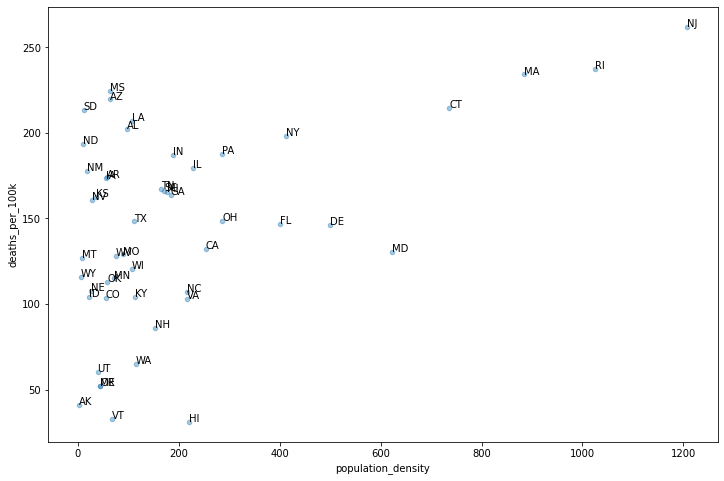

In [212]:
# Exclude DC in chart because it throws the x axis off and makes it hard to read
ax = deaths_by_state.dropna(subset=['population_density','deaths_per_100k']).drop('DC').plot(alpha=0.4,figsize=(12,8),x='population_density',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state.dropna(subset=['population_density','deaths_per_100k']).drop('DC').iterrows():
    ax.text(row['population_density'], row['deaths_per_100k'], str(index))

In [213]:
deaths_by_state['deaths_per_100k'].corr(deaths_by_state['population_density'])
# Try pearson correlation
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['population_density'], method="pearson")
print("Correlation coefficient between population density and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman, data appears potentially monotonic
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['population_density'], method="spearman");
print("Correlation coefficient between population density and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between population density and deaths per 100k (Method:Pearson)
0.0783
Correlation coefficient between population density and deaths per 100k (Method:Spearman rank correlation coefficient)
0.3041


In [214]:
# Retrieve age data for states
state_age_data = requests.get("http://api.census.gov/data/2019/pep/charage?get=AGE,POP&for=state:*").json()

In [215]:
deaths_by_state['average_age'] = np.nan
deaths_by_state['total_over_60'] = 0
deaths_by_state['total_over_60_pct'] = np.nan
# Calculate average age for each state
for index, row in deaths_by_state.iterrows():
    state_id = row['state_id']
    ages = np.array([])
    weights = np.array([])
    total_over_60 = 0
    for data in state_age_data[1:]:
        # Bad data
        if int(data[0]) == 999:
            continue
        if state_id == data[2]:
            ages = np.append(ages, int(data[0]))
            weights = np.append(weights, int(data[1]))
            # Record population over 60
            if int(data[0]) >= 60:
                total_over_60 = total_over_60 + int(data[1])
    if len(weights) == 0:
        print('could not get age data for {}'.format(index))
        continue
    deaths_by_state.at[index, 'average_age'] = np.average(ages, weights=weights)
    deaths_by_state.at[index, 'total_over_60'] = total_over_60
deaths_by_state['total_over_60_pct'] = deaths_by_state['total_over_60'] / deaths_by_state['population']

could not get age data for AS
could not get age data for GU
could not get age data for MP
could not get age data for VI


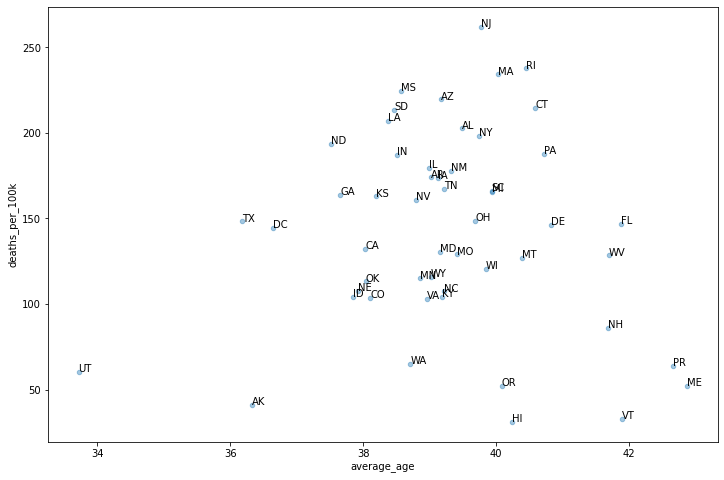

In [216]:
ax = deaths_by_state.dropna(subset=['average_age','deaths_per_100k']).plot(alpha=0.4,figsize=(12,8),x='average_age',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state.dropna(subset=['average_age','deaths_per_100k']).iterrows():
    ax.text(row['average_age'], row['deaths_per_100k'], str(index))

In [217]:
# Try pearson correlation
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['average_age'], method="pearson")
print("Correlation coefficient between average age and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['average_age'], method="spearman")
print("Correlation coefficient between average age and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between average age and deaths per 100k (Method:Pearson)
-0.0324
Correlation coefficient between average age and deaths per 100k (Method:Spearman rank correlation coefficient)
-0.0146


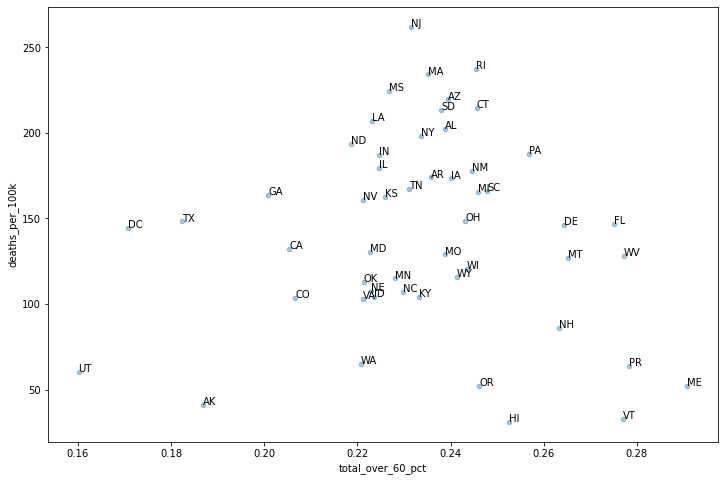

In [218]:
ax = deaths_by_state.dropna(subset=['total_over_60_pct','deaths_per_100k']).plot(alpha=0.4,figsize=(12,8),x='total_over_60_pct',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state.dropna(subset=['total_over_60_pct','deaths_per_100k']).iterrows():
    ax.text(row['total_over_60_pct'], row['deaths_per_100k'], str(index))

In [219]:
# Try pearson correlation
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['total_over_60_pct'], method="pearson")
print("Correlation coefficient between total over 60 (percentage) and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman
corr_value = deaths_by_state['deaths_per_100k'].corr(deaths_by_state['total_over_60_pct'], method="spearman");
print("Correlation coefficient between total over 60 (percentage) and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between total over 60 (percentage) and deaths per 100k (Method:Pearson)
-0.0456
Correlation coefficient between total over 60 (percentage) and deaths per 100k (Method:Spearman rank correlation coefficient)
-0.0172


In [220]:
# Insert the lockdown days for each state
deaths_by_state['days_in_lockdown'] = np.nan
deaths_by_state['days_in_lockdown_relative'] = np.nan
deaths_by_state['did_lockdown'] = False
for index, row in deaths_by_state.iterrows():
    if str(index) not in statewide_lockdown_days.keys():
        print('no lockdown data for {}'.format(index))
        continue
    deaths_by_state.at[index, 'days_in_lockdown'] = statewide_lockdown_days[str(index)]
    deaths_by_state.at[index, 'did_lockdown'] = statewide_lockdown_days[str(index)] > 0
    if str(index) in first_lockdown_date.keys():
        delta_relative = first_lockdown_date[str(index)] - first_lockdown_state_date
        deaths_by_state.at[index, 'days_in_lockdown_relative'] = delta_relative.days

no lockdown data for AS
no lockdown data for GU
no lockdown data for MP
no lockdown data for PR
no lockdown data for VI


In [221]:
deaths_by_state_lockdown_data = deaths_by_state[['deaths_per_100k', 'days_in_lockdown', 'days_in_lockdown_relative', 'did_lockdown']]

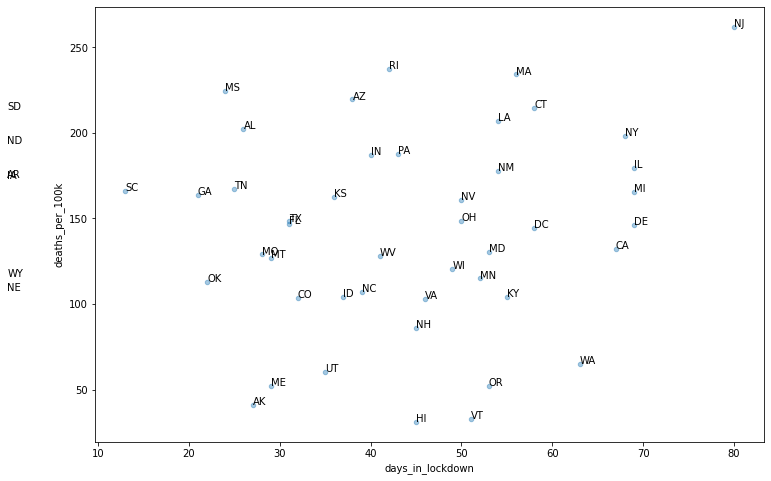

In [222]:
# For states that did lockdown, plot days in lockdown vs deaths
ax = deaths_by_state_lockdown_data[deaths_by_state_lockdown_data['did_lockdown']].dropna(subset=['days_in_lockdown','deaths_per_100k']).plot(alpha=0.4,figsize=(12,8),x='days_in_lockdown',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state_lockdown_data.dropna(subset=['days_in_lockdown','deaths_per_100k']).iterrows():
    ax.text(row['days_in_lockdown'], row['deaths_per_100k'], str(index))


In [223]:
states_in_lockdown = deaths_by_state_lockdown_data[deaths_by_state_lockdown_data['did_lockdown']]
# Try pearson correlation
corr_value = states_in_lockdown['deaths_per_100k'].corr(states_in_lockdown['days_in_lockdown'], method="pearson")
print("Correlation coefficient between number of days in lockdown (for states that did lockdown) and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = states_in_lockdown['deaths_per_100k'].corr(states_in_lockdown['days_in_lockdown'], method="spearman");
print("Correlation coefficient between number of days in lockdown (for states that did lockdown) and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

# All States
## Try pearson correlation
corr_value = deaths_by_state_lockdown_data['deaths_per_100k'].corr(deaths_by_state_lockdown_data['days_in_lockdown'], method="pearson")
print("Correlation coefficient between number of days in lockdown (for all states) and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

## Try spearman correlation
corr_value = deaths_by_state_lockdown_data['deaths_per_100k'].corr(deaths_by_state_lockdown_data['days_in_lockdown'], method="spearman");
print("Correlation coefficient between number of days in lockdown (for all states) and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))


Correlation coefficient between number of days in lockdown (for states that did lockdown) and deaths per 100k (Method:Pearson)
0.1615
Correlation coefficient between number of days in lockdown (for states that did lockdown) and deaths per 100k (Method:Spearman rank correlation coefficient)
0.1327
Correlation coefficient between number of days in lockdown (for all states) and deaths per 100k (Method:Pearson)
0.0253
Correlation coefficient between number of days in lockdown (for all states) and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0371


In [224]:
# Average deaths per 100k for states that did not lockdown
no_lockdown_mean = deaths_by_state_lockdown_data[~deaths_by_state_lockdown_data['did_lockdown']]['deaths_per_100k'].mean()
no_lockdown_std = deaths_by_state_lockdown_data[~deaths_by_state_lockdown_data['did_lockdown']]['deaths_per_100k'].std()
print('average deaths per 100k for no lockdown states: {} (std: {})'.format(no_lockdown_mean, no_lockdown_std))

# Average deaths per 100k for states that did lockdown
lockdown_mean = states_in_lockdown['deaths_per_100k'].mean()
lockdown_std = states_in_lockdown['deaths_per_100k'].std()
print('average deaths per 100k for lockdown states: {} (std: {})'.format(lockdown_mean, lockdown_std))

# Average deaths per 100k for top 5 states with longest lockdowns
top_lockdown_mean = states_in_lockdown.sort_values(by='days_in_lockdown', ascending=False).head(5)['deaths_per_100k'].mean()
top_lockdown_std = states_in_lockdown.sort_values(by='days_in_lockdown', ascending=False).head(5)['deaths_per_100k'].std()
print('average deaths per 100k for top 5 lockdown states: {} (std: {})'.format(top_lockdown_mean, top_lockdown_std))

# Average deaths per 100k for all states
all_mean = deaths_by_state_lockdown_data['deaths_per_100k'].mean()
all_std = deaths_by_state_lockdown_data['deaths_per_100k'].std()
print('average deaths per 100k for all states: {} (std: {})'.format(all_mean, all_std))


average deaths per 100k for no lockdown states: 148.81736546591918 (std: 53.88467803659894)
average deaths per 100k for lockdown states: 142.02830937765998 (std: 57.86485842598508)
average deaths per 100k for top 5 lockdown states: 190.27272843225907 (std: 44.4449128998429)
average deaths per 100k for all states: 142.9422207741564 (std: 56.88440272795582)


In [225]:
# Include states that did not lockdown in correlation
# Try pearson correlation
corr_value = deaths_by_state_lockdown_data['deaths_per_100k'].corr(deaths_by_state_lockdown_data['days_in_lockdown'], method="pearson")
print("Correlation coefficient between number of days in lockdown and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = deaths_by_state_lockdown_data['deaths_per_100k'].corr(deaths_by_state_lockdown_data['days_in_lockdown'], method="spearman");
print("Correlation coefficient between number of days in lockdown and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between number of days in lockdown and deaths per 100k (Method:Pearson)
0.0253
Correlation coefficient between number of days in lockdown and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0371


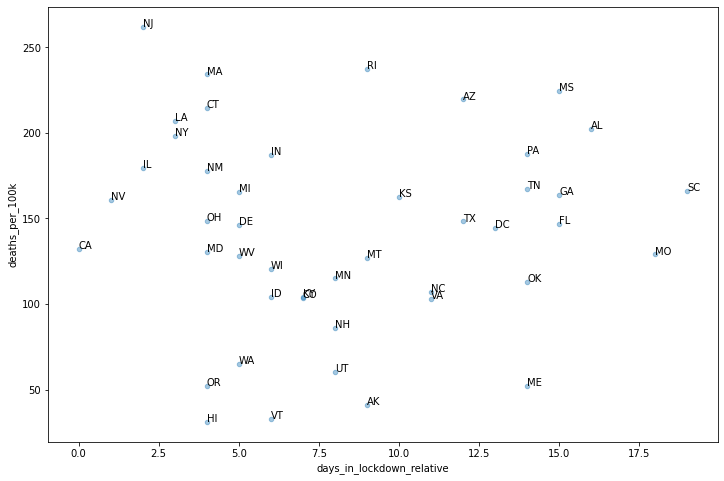

In [226]:
# For states that did lockdown, plot days in lockdown relative to first lockdown vs deaths
ax = states_in_lockdown.dropna(subset=['days_in_lockdown_relative','deaths_per_100k']).plot(alpha=0.4,figsize=(12,8),x='days_in_lockdown_relative',y='deaths_per_100k',kind='scatter')
for index, row in states_in_lockdown.dropna(subset=['days_in_lockdown_relative','deaths_per_100k']).iterrows():
    ax.text(row['days_in_lockdown_relative'], row['deaths_per_100k'], str(index))


In [227]:
# Try pearson correlation
corr_value = states_in_lockdown['deaths_per_100k'].corr(states_in_lockdown['days_in_lockdown_relative'], method="pearson")
print("Correlation coefficient between relative number of days before lockdown and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = states_in_lockdown['deaths_per_100k'].corr(states_in_lockdown['days_in_lockdown_relative'], method="spearman");
print("Correlation coefficient between relative number of days before lockdown and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between relative number of days before lockdown and deaths per 100k (Method:Pearson)
0.014
Correlation coefficient between relative number of days before lockdown and deaths per 100k (Method:Spearman rank correlation coefficient)
-0.0512


In [228]:
# Add mask mandate data
deaths_by_state['mask_order_start_date'] = np.nan
deaths_by_state['mask_order_days'] = 0
deaths_by_state['mask_order_days_relative'] = np.nan
deaths_by_state['did_mask_order'] = False
for index, row in deaths_by_state.iterrows():
    if str(index) in mask_mandate_start_date.keys():
        mask_order_end_date = datetime.now()
        if str(index) in mask_mandate_end_date.keys():
            mask_order_end_date = mask_mandate_end_date[str(index)]
        delta = mask_order_end_date - mask_mandate_start_date[str(index)]
        delta_relative = mask_mandate_start_date[str(index)] - first_mask_order_date
        deaths_by_state.at[index, 'mask_order_start_date'] = mask_mandate_start_date[str(index)]
        deaths_by_state.at[index, 'mask_order_days'] = delta.days
        deaths_by_state.at[index, 'mask_order_days_relative'] = delta_relative.days
        deaths_by_state.at[index, 'did_mask_order'] = True

In [229]:
deaths_by_state_mask_data = deaths_by_state[['deaths_per_100k', 'mask_order_start_date', 'mask_order_days', 'mask_order_days_relative', 'did_mask_order']]

In [230]:
# Average deaths per 100k for states that did not do a mask order
no_mask_order_mean = deaths_by_state_mask_data[~deaths_by_state_mask_data['did_mask_order']]['deaths_per_100k'].mean()
print('average deaths per 100k for no mask order states: {}'.format(no_mask_order_mean))

# Average deaths per 100k for states that did do a mask order
mask_order_mean = deaths_by_state_mask_data[deaths_by_state_mask_data['did_mask_order']]['deaths_per_100k'].mean()
print('average deaths per 100k for mask order states: {}'.format(mask_order_mean))

average deaths per 100k for no mask order states: 139.9270464721053
average deaths per 100k for mask order states: 144.5384895223011


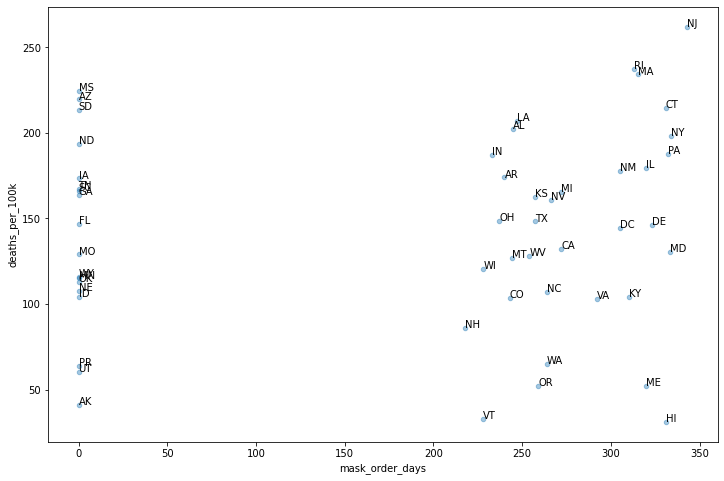

In [231]:
# Examine correlation between number of days under mask order and death rate (among states that have a mask order)
deaths_by_state_mask_data_did_masks = deaths_by_state_mask_data.dropna(subset=['mask_order_days','deaths_per_100k'])
ax = deaths_by_state_mask_data_did_masks.plot(alpha=0.4,figsize=(12,8),x='mask_order_days',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state_mask_data_did_masks.iterrows():
    ax.text(row['mask_order_days'], row['deaths_per_100k'], str(index))


In [232]:
# Try pearson correlation
corr_value = deaths_by_state_mask_data_did_masks['deaths_per_100k'].corr(deaths_by_state_mask_data_did_masks['mask_order_days'], method="pearson")
print("Correlation coefficient between number of days in mask order and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = deaths_by_state_mask_data_did_masks['deaths_per_100k'].corr(deaths_by_state_mask_data_did_masks['mask_order_days'], method="spearman");
print("Correlation coefficient between number of days in mask order and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between number of days in mask order and deaths per 100k (Method:Pearson)
0.0915
Correlation coefficient between number of days in mask order and deaths per 100k (Method:Spearman rank correlation coefficient)
0.1531


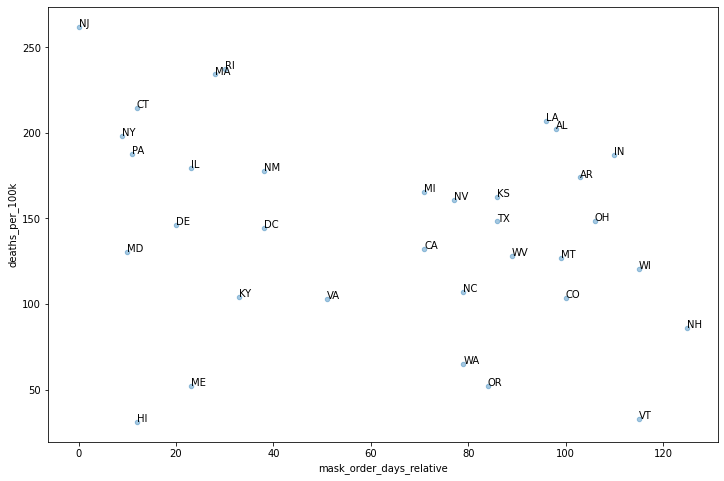

In [233]:
ax = deaths_by_state_mask_data_did_masks.dropna(subset=['mask_order_days_relative','deaths_per_100k']).plot(alpha=0.4,figsize=(12,8),x='mask_order_days_relative',y='deaths_per_100k',kind='scatter')
for index, row in deaths_by_state_mask_data_did_masks.dropna(subset=['mask_order_days_relative','deaths_per_100k']).iterrows():
    ax.text(row['mask_order_days_relative'], row['deaths_per_100k'], str(index))


In [234]:
# Try pearson correlation
corr_value = deaths_by_state_mask_data_did_masks['deaths_per_100k'].corr(deaths_by_state_mask_data_did_masks['mask_order_days_relative'], method="pearson")
print("Correlation coefficient between relative number of days until mask order in effect and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = deaths_by_state_mask_data_did_masks['deaths_per_100k'].corr(deaths_by_state_mask_data_did_masks['mask_order_days_relative'], method="spearman");
print("Correlation coefficient between relative number of days until mask order in effect and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between relative number of days until mask order in effect and deaths per 100k (Method:Pearson)
-0.2849
Correlation coefficient between relative number of days until mask order in effect and deaths per 100k (Method:Spearman rank correlation coefficient)
-0.2891


In [235]:
mask_non_compliance_by_state['geo_value'] = mask_non_compliance_by_state['geo_value'].str.upper()
mask_non_compliance_by_state_deaths = mask_non_compliance_by_state.set_index(['time_value','geo_value'])
mask_non_compliance_by_state_deaths = mask_non_compliance_by_state_deaths.groupby(['geo_value']).mean()['value'].to_frame()
mask_non_compliance_by_state_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

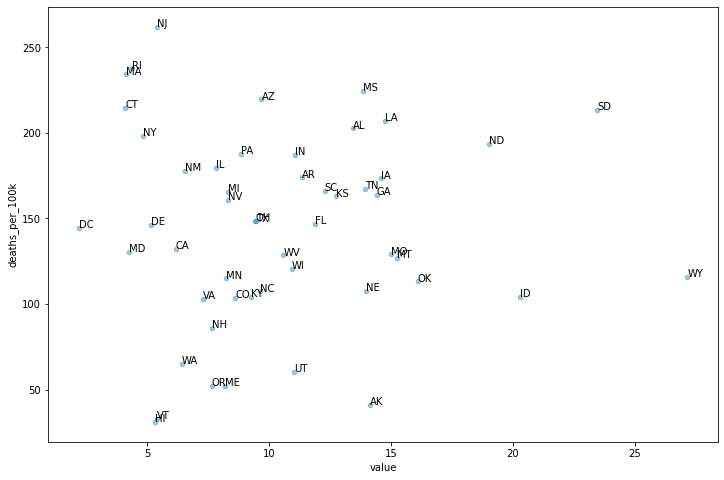

In [236]:
ax = mask_non_compliance_by_state_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='value',y='deaths_per_100k',kind='scatter')
for index, row in mask_non_compliance_by_state_deaths.dropna().iterrows():
    ax.text(row['value'], row['deaths_per_100k'], str(index))


In [237]:
# Try pearson correlation
corr_value = mask_non_compliance_by_state_deaths['deaths_per_100k'].corr(mask_non_compliance_by_state_deaths['value'], method="pearson")
print("Correlation coefficient between average mask non-compliance and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mask_non_compliance_by_state_deaths['deaths_per_100k'].corr(mask_non_compliance_by_state_deaths['value'], method="spearman")
print("Correlation coefficient between average mask non-compliance and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between average mask non-compliance and deaths per 100k (Method:Pearson)
0.0234
Correlation coefficient between average mask non-compliance and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0118


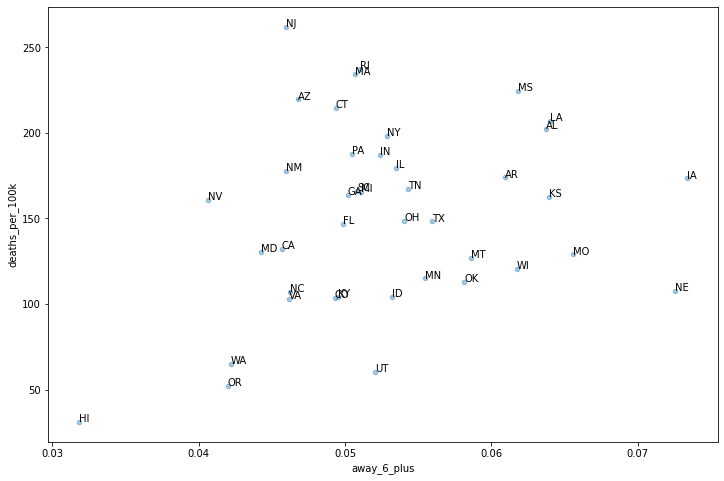

In [238]:
# Mobility: Away 6+ hours
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='away_6_plus',y='deaths_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['away_6_plus'], row['deaths_per_100k'], str(index))


In [239]:
# Try pearson correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['away_6_plus'], method="pearson")
print("Correlation coefficient between fraction of population away 6+ hours a day and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['away_6_plus'], method="spearman")
print("Correlation coefficient between fraction of population away 6+ hours a day and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between fraction of population away 6+ hours a day and deaths per 100k (Method:Pearson)
0.1554
Correlation coefficient between fraction of population away 6+ hours a day and deaths per 100k (Method:Spearman rank correlation coefficient)
0.1171


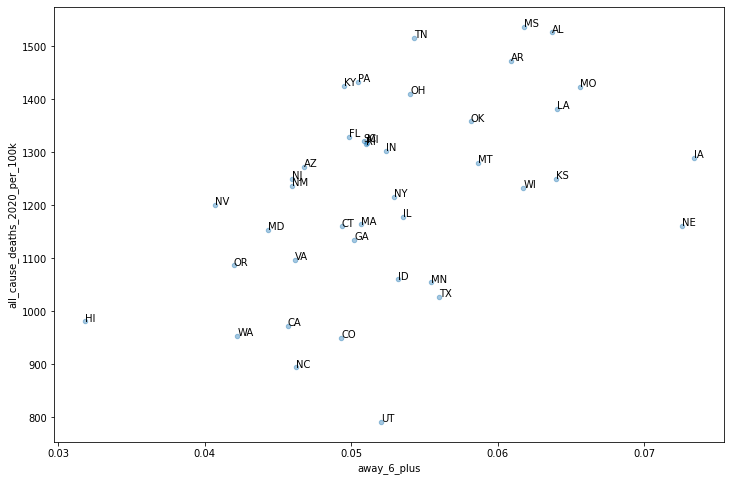

In [240]:
# Mobility: Away 6+ hours (all-cause mortality - 2020)
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='away_6_plus',y='all_cause_deaths_2020_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['away_6_plus'], row['all_cause_deaths_2020_per_100k'], str(index))


In [241]:
# Try pearson correlation
corr_value = mobility_data_by_state['all_cause_deaths_2020_per_100k'].corr(mobility_data_by_state['away_6_plus'], method="pearson")
print("Correlation coefficient between fraction of population away 6+ hours a day and all cause deaths per 100k in 2020 (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['all_cause_deaths_2020_per_100k'].corr(mobility_data_by_state['away_6_plus'], method="spearman");
print("Correlation coefficient between fraction of population away 6+ hours a day and all cause deaths per 100k in 2020 (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between fraction of population away 6+ hours a day and all cause deaths per 100k in 2020 (Method:Pearson)
0.281
Correlation coefficient between fraction of population away 6+ hours a day and all cause deaths per 100k in 2020 (Method:Spearman rank correlation coefficient)
0.3338


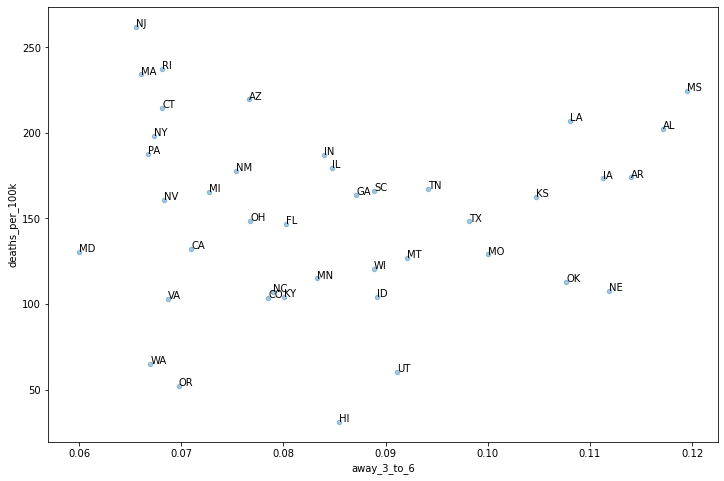

In [242]:
# Mobility: Away 3-6 hours
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='away_3_to_6',y='deaths_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['away_3_to_6'], row['deaths_per_100k'], str(index))


In [243]:
# Try pearson correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['away_3_to_6'], method="pearson")
print("Correlation coefficient between fraction of population away 3-6 hours a day and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['away_3_to_6'], method="spearman");
print("Correlation coefficient between fraction of population away 3-6 hours a day and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between fraction of population away 3-6 hours a day and deaths per 100k (Method:Pearson)
0.1475
Correlation coefficient between fraction of population away 3-6 hours a day and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0558


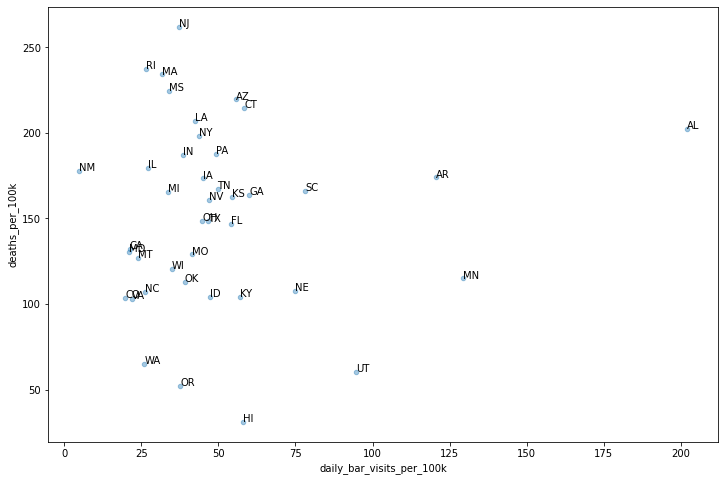

In [244]:
# Mobility: Bar visits
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='daily_bar_visits_per_100k',y='deaths_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['daily_bar_visits_per_100k'], row['deaths_per_100k'], str(index))


In [245]:
# Try pearson correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['daily_bar_visits_per_100k'], method="pearson")
print("Correlation coefficient between bar visits per day per 100k and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['daily_bar_visits_per_100k'], method="spearman");
print("Correlation coefficient between bar visits per day per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between bar visits per day per 100k and deaths per 100k (Method:Pearson)
0.0795
Correlation coefficient between bar visits per day per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0907


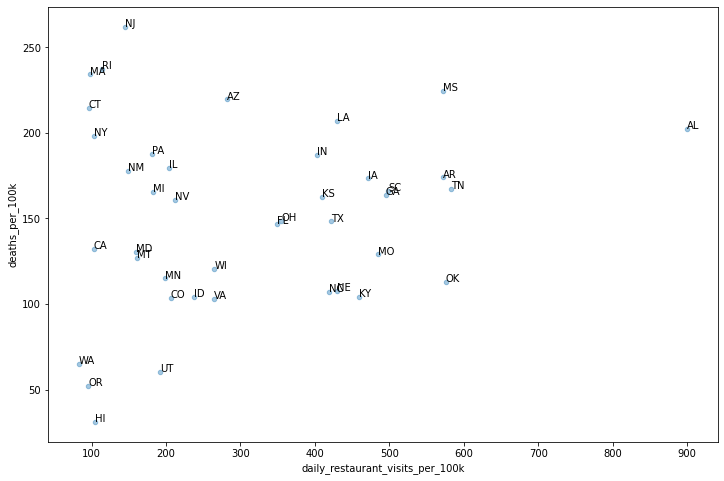

In [246]:
# Mobility: Restaurant visits
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='daily_restaurant_visits_per_100k',y='deaths_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['daily_restaurant_visits_per_100k'], row['deaths_per_100k'], str(index))


In [247]:
# Try pearson correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['daily_restaurant_visits_per_100k'], method="pearson")
print("Correlation coefficient between restaurant visits per day per 100k and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['daily_restaurant_visits_per_100k'], method="spearman");
print("Correlation coefficient between restaurant visits per day per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between restaurant visits per day per 100k and deaths per 100k (Method:Pearson)
0.2777
Correlation coefficient between restaurant visits per day per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)
0.2264


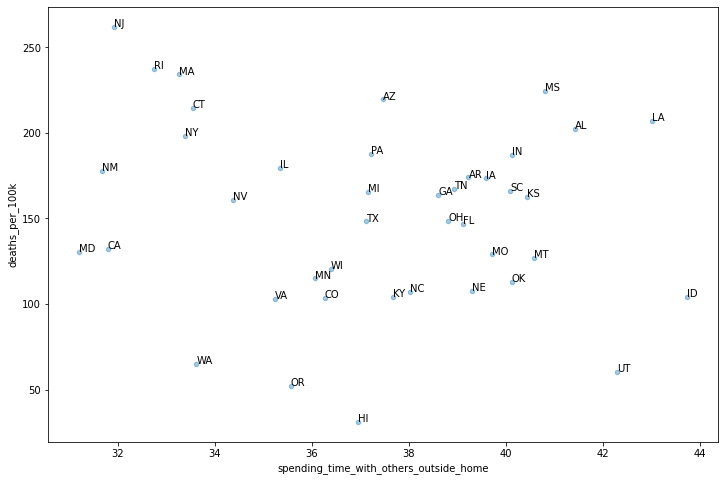

In [248]:
# Social distancing (spending time with others)
ax = mobility_data_by_state.dropna().plot(alpha=0.4,figsize=(12,8),x='spending_time_with_others_outside_home',y='deaths_per_100k',kind='scatter')
for index, row in mobility_data_by_state.dropna().iterrows():
    ax.text(row['spending_time_with_others_outside_home'], row['deaths_per_100k'], str(index))

In [249]:
# Try pearson correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['spending_time_with_others_outside_home'], method="pearson")
print("Correlation coefficient between spending time with others outside home per 100k and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = mobility_data_by_state['deaths_per_100k'].corr(mobility_data_by_state['spending_time_with_others_outside_home'], method="spearman");
print("Correlation coefficient between spending time with others outside home per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between spending time with others outside home per 100k and deaths per 100k (Method:Pearson)
0.0307
Correlation coefficient between spending time with others outside home per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)
0.0604


In [250]:
type_2_diabetes_rate_deaths = pd.DataFrame(list(type_2_diabetes_rate.items()),columns = ['state', 'type_2_diabetes_rate']).set_index(['state'])
type_2_diabetes_rate_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

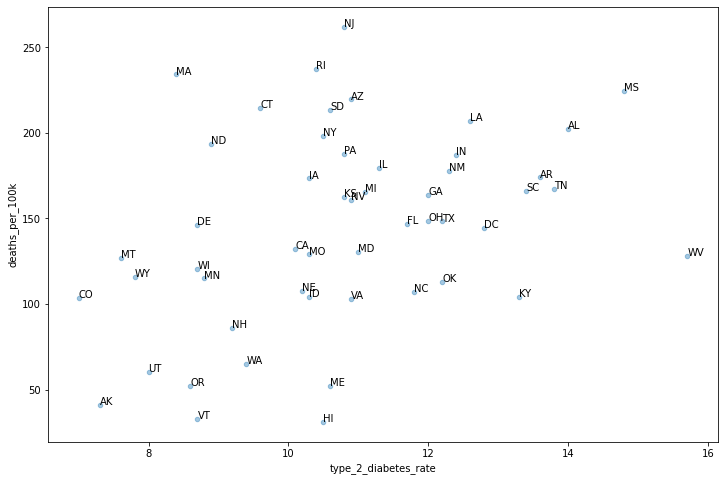

In [251]:
# Type 2 Diabetes rate
ax = type_2_diabetes_rate_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='type_2_diabetes_rate',y='deaths_per_100k',kind='scatter')
for index, row in type_2_diabetes_rate_deaths.dropna().iterrows():
    ax.text(row['type_2_diabetes_rate'], row['deaths_per_100k'], str(index))


In [252]:
# Try pearson correlation
corr_value = type_2_diabetes_rate_deaths['deaths_per_100k'].corr(type_2_diabetes_rate_deaths['type_2_diabetes_rate'], method="pearson")
print("Correlation coefficient between type 2 diabetes rate and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = type_2_diabetes_rate_deaths['deaths_per_100k'].corr(type_2_diabetes_rate_deaths['type_2_diabetes_rate'], method="spearman")
print("Correlation coefficient between type 2 diabetes rate and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between type 2 diabetes rate and deaths per 100k (Method:Pearson)
0.3646
Correlation coefficient between type 2 diabetes rate and deaths per 100k (Method:Spearman rank correlation coefficient)
0.3818


In [253]:
obesity_rate_deaths = pd.DataFrame(list(obesity_rates.items()),columns = ['state', 'obesity_rate']).set_index(['state'])
obesity_rate_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

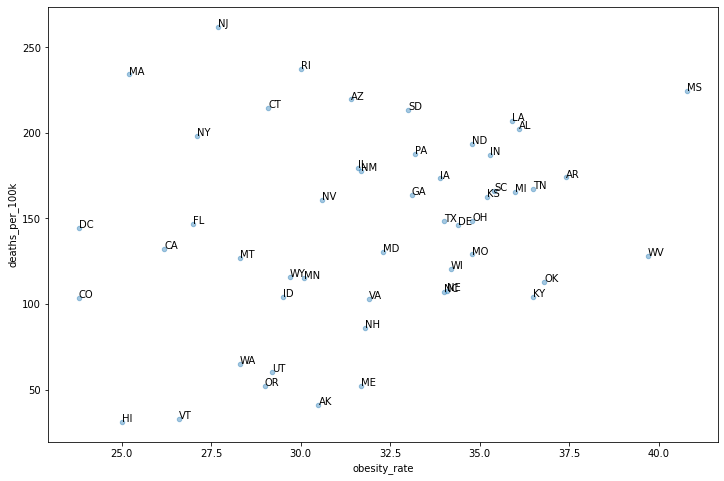

In [254]:
# Obesity rate
ax = obesity_rate_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='obesity_rate',y='deaths_per_100k',kind='scatter')
for index, row in obesity_rate_deaths.dropna().iterrows():
    ax.text(row['obesity_rate'], row['deaths_per_100k'], str(index))

In [255]:
# Try pearson correlation
corr_value = obesity_rate_deaths['deaths_per_100k'].corr(obesity_rate_deaths['obesity_rate'], method="pearson")
print("Correlation coefficient between obesity rate and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = obesity_rate_deaths['deaths_per_100k'].corr(obesity_rate_deaths['obesity_rate'], method="spearman");
print("Correlation coefficient between obesity rate and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between obesity rate and deaths per 100k (Method:Pearson)
0.2377
Correlation coefficient between obesity rate and deaths per 100k (Method:Spearman rank correlation coefficient)
0.2336


In [256]:
heart_disease_deaths = pd.DataFrame(list(heart_disease_death_rates.items()),columns = ['state', 'heart_disease_deaths_per_100k']).set_index(['state'])
heart_disease_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

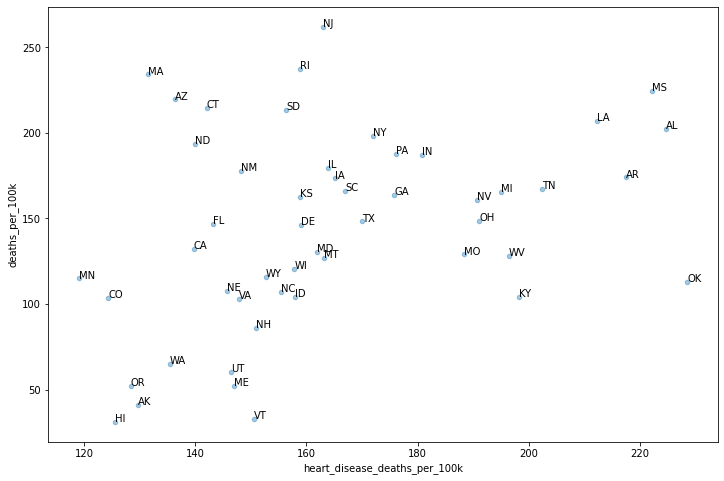

In [257]:
# Heart disease death rate
ax = heart_disease_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='heart_disease_deaths_per_100k',y='deaths_per_100k',kind='scatter')
for index, row in heart_disease_deaths.dropna().iterrows():
    ax.text(row['heart_disease_deaths_per_100k'], row['deaths_per_100k'], str(index))

In [258]:
# Try pearson correlation
corr_value = heart_disease_deaths['deaths_per_100k'].corr(heart_disease_deaths['heart_disease_deaths_per_100k'], method="pearson")
print("Correlation coefficient between heart disease death rate per 100k and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = heart_disease_deaths['deaths_per_100k'].corr(heart_disease_deaths['heart_disease_deaths_per_100k'], method="spearman");
print("Correlation coefficient between heart disease death rate per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between heart disease death rate per 100k and deaths per 100k (Method:Pearson)
0.3529
Correlation coefficient between heart disease death rate per 100k and deaths per 100k (Method:Spearman rank correlation coefficient)
0.3799


In [259]:
copd_rate_deaths = pd.DataFrame(list(copd_rates.items()),columns = ['state', 'copd_rate']).set_index(['state'])
copd_rate_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

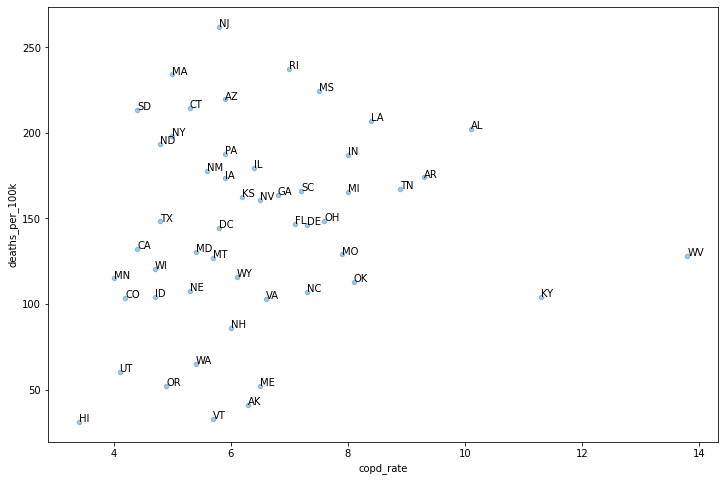

In [260]:
# COPD rate
ax = copd_rate_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='copd_rate',y='deaths_per_100k',kind='scatter')
for index, row in copd_rate_deaths.dropna().iterrows():
    ax.text(row['copd_rate'], row['deaths_per_100k'], str(index))

In [261]:
# Try pearson correlation
corr_value = copd_rate_deaths['deaths_per_100k'].corr(copd_rate_deaths['copd_rate'], method="pearson")
print("Correlation coefficient between copd rate and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = copd_rate_deaths['deaths_per_100k'].corr(copd_rate_deaths['copd_rate'], method="spearman");
print("Correlation coefficient between copd rate and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between copd rate and deaths per 100k (Method:Pearson)
0.1619
Correlation coefficient between copd rate and deaths per 100k (Method:Spearman rank correlation coefficient)
0.2077


In [262]:
health_rank_deaths = pd.DataFrame(list(health_rank.items()),columns = ['state', 'health_rank']).set_index(['state'])
health_rank_deaths['deaths_per_100k'] = deaths_by_state['deaths_per_100k']

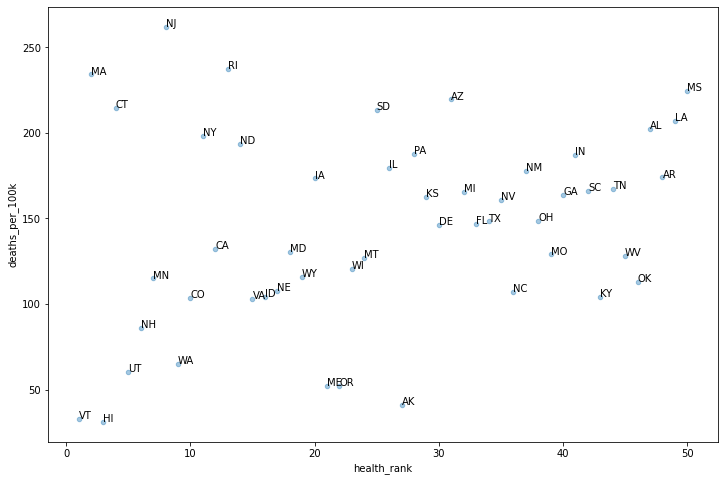

In [263]:
# Health rank
ax = health_rank_deaths.dropna().plot(alpha=0.4,figsize=(12,8),x='health_rank',y='deaths_per_100k',kind='scatter')
for index, row in health_rank_deaths.dropna().iterrows():
    ax.text(row['health_rank'], row['deaths_per_100k'], str(index))

In [264]:
# Try pearson correlation
corr_value = health_rank_deaths['deaths_per_100k'].corr(health_rank_deaths['health_rank'], method="pearson")
print("Correlation coefficient between health rank (lower is better) and deaths per 100k (Method:Pearson)")
print(round(corr_value,4))

# Try spearman correlation
corr_value = health_rank_deaths['deaths_per_100k'].corr(health_rank_deaths['health_rank'], method="spearman");
print("Correlation coefficient between health rank (lower is better) and deaths per 100k (Method:Spearman rank correlation coefficient)")
print(round(corr_value,4))

Correlation coefficient between health rank (lower is better) and deaths per 100k (Method:Pearson)
0.2636
Correlation coefficient between health rank (lower is better) and deaths per 100k (Method:Spearman rank correlation coefficient)
0.2667


In [265]:
# Control for non-NPI variables
controlled_corr = deaths_by_state['deaths_per_100k'].to_frame()
#controlled_corr['all_cause_deaths_2019_per_100k'] = mobility_data_by_state['all_cause_deaths_2019_per_100k']
controlled_corr['all_cause_deaths_2020_per_100k'] = mobility_data_by_state['all_cause_deaths_2020_per_100k']
#controlled_corr['all_cause_deaths_increase_per_100k'] = mobility_data_by_state['all_cause_deaths_increase_per_100k']
controlled_corr['non_covid_deaths_2020_per_100k'] = mobility_data_by_state['non_covid_deaths_2020_per_100k']
## Add NPIs
controlled_corr = controlled_corr.join(mask_non_compliance_by_state_deaths['value'].to_frame().rename(index={'geo_value': 'state'}, columns={'value': 'mask_non_compliance_rate'}), on=['state']) # Reported mask 'non-compliance' rate per state
controlled_corr = controlled_corr.join(mobility_data_by_state['away_6_plus'].to_frame(), on=['state']) # Average percentage of population away 6+ hourse per day per state
controlled_corr = controlled_corr.join(mobility_data_by_state['away_3_to_6'].to_frame(), on=['state']) # Average percentage of population away 3-6 hourse per day per state
controlled_corr = controlled_corr.join(mobility_data_by_state['spending_time_with_others_outside_home'].to_frame(), on=['state'])
#controlled_corr = controlled_corr.join(mobility_data_by_state['daily_bar_visits_per_100k'].to_frame(), on=['state']) - many states don't have any data on this
controlled_corr = controlled_corr.join(mobility_data_by_state['daily_restaurant_visits_per_100k'].to_frame(), on=['state'])
#controlled_corr = controlled_corr.join(deaths_by_state_lockdown_data['days_in_lockdown'])
## Add health data
controlled_corr = controlled_corr.join(type_2_diabetes_rate_deaths['type_2_diabetes_rate'], on=['state']) # Type 2 Diabetes Rate per state
controlled_corr = controlled_corr.join(heart_disease_deaths['heart_disease_deaths_per_100k'], on=['state']) # Heart Disease Death Rate per state
controlled_corr = controlled_corr.join(obesity_rate_deaths['obesity_rate'], on=['state']) # Obesity Rate per state
controlled_corr = controlled_corr.join(copd_rate_deaths['copd_rate'], on=['state']) # COPD Rate per state
controlled_corr = controlled_corr.join(health_rank_deaths['health_rank'], on=['state']) # Average 'health rank' per state
## Population data
controlled_corr = controlled_corr.join(deaths_by_state['population_density'], on=['state'])
## Testing data
#controlled_corr = controlled_corr.join(deaths_by_state['tests_per_100k'], on=['state'])
### All covariants
covariants = ['mask_non_compliance_rate', 'away_6_plus', 'away_3_to_6', 'daily_restaurant_visits_per_100k', 'type_2_diabetes_rate', 'heart_disease_deaths_per_100k', 'obesity_rate', 'copd_rate', 'health_rank', 'population_density','spending_time_with_others_outside_home']

In [266]:
### Partial Pearson correlation (COVID deaths)
corr_df_pearson = None
for cov in covariants:
    if corr_df_pearson is None:
        corr_df_pearson = pg.partial_corr(data=controlled_corr, x=cov, y='deaths_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3)
        continue
    corr_df_pearson = corr_df_pearson.append(pg.partial_corr(data=controlled_corr, x=cov, y='deaths_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3))
corr_df_pearson['r_abs'] = corr_df_pearson['r'].abs()
corr_df_pearson['null_hyp_likely'] = corr_df_pearson['p-val'] > .05
corr_df_pearson.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r           CI95%     r2  \
population_density                      50  0.702    [0.53, 0.82]  0.493   
away_6_plus                             50  0.434    [0.18, 0.64]  0.189   
health_rank                             50  0.391     [0.13, 0.6]  0.153   
copd_rate                               50 -0.358  [-0.58, -0.09]  0.128   
type_2_diabetes_rate                    50  0.348    [0.08, 0.57]  0.121   
daily_restaurant_visits_per_100k        50 -0.127   [-0.39, 0.16]  0.016   
obesity_rate                            50 -0.104   [-0.37, 0.18]  0.011   
away_3_to_6                             50 -0.093   [-0.36, 0.19]  0.009   
mask_non_compliance_rate                50  0.080    [-0.2, 0.35]  0.006   
spending_time_with_others_outside_home  50  0.053   [-0.23, 0.33]  0.003   
heart_disease_deaths_per_100k           50  0.049   [-0.23, 0.32]  0.002   

                                        adj_r2  p-val       BF10  power  \
population_density                       0.472  0.000  1.137e+06  1.000   
away_6_plus                              0.154  0.002     21.947  0.896   
health_rank                              0.117  0.005      8.139  0.815   
copd_rate                                0.091  0.011      4.184  0.736   
type_2_diabetes_rate                     0.084  0.013      3.472  0.709   
daily_restaurant_visits_per_100k        -0.026  0.381      0.256  0.142   
obesity_rate                            -0.031  0.472      0.227  0.111   
away_3_to_6                             -0.034  0.520      0.216  0.099   
mask_non_compliance_rate                -0.036  0.580      0.205  0.086   
spending_time_with_others_outside_home  -0.040  0.715      0.188  0.065   
heart_disease_deaths_per_100k           -0.040  0.734      0.187  0.063   

                                        null_hyp_likely  
population_density                                False  
away_6_plus                                       False  
health_rank                                       False  
copd_rate                                         False  
type_2_diabetes_rate                              False  
daily_restaurant_visits_per_100k                   True  
obesity_rate                                       True  
away_3_to_6                                        True  
mask_non_compliance_rate                           True  
spending_time_with_others_outside_home             True  
heart_disease_deaths_per_100k                      True

In [267]:
### Partial Spearman Correlation (COVID deaths)
corr_df_spearman = None
for cov in covariants:
    if corr_df_spearman is None:
        corr_df_spearman = pg.partial_corr(data=controlled_corr, x=cov, y='deaths_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3)
        continue
    corr_df_spearman = corr_df_spearman.append(pg.partial_corr(data=controlled_corr, x=cov, y='deaths_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3))
corr_df_spearman['r_abs'] = corr_df_spearman['r'].abs()
corr_df_spearman['null_hyp_likely'] = corr_df_spearman['p-val'] > .05
corr_df_spearman.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r           CI95%     r2  \
population_density                      50  0.520     [0.28, 0.7]  0.270   
health_rank                             50  0.361    [0.09, 0.58]  0.130   
copd_rate                               50 -0.353  [-0.57, -0.08]  0.125   
away_6_plus                             50  0.342    [0.07, 0.57]  0.117   
type_2_diabetes_rate                    50  0.283    [0.01, 0.52]  0.080   
daily_restaurant_visits_per_100k        50 -0.217   [-0.47, 0.07]  0.047   
obesity_rate                            50 -0.155   [-0.42, 0.13]  0.024   
spending_time_with_others_outside_home  50  0.083    [-0.2, 0.35]  0.007   
away_3_to_6                             50 -0.079    [-0.35, 0.2]  0.006   
heart_disease_deaths_per_100k           50  0.070   [-0.21, 0.34]  0.005   
mask_non_compliance_rate                50 -0.016   [-0.29, 0.26]  0.000   

                                        adj_r2  p-val  power  null_hyp_likely  
population_density                       0.239  0.000  0.979            False  
health_rank                              0.093  0.010  0.743            False  
copd_rate                                0.087  0.012  0.723            False  
away_6_plus                              0.079  0.015  0.692            False  
type_2_diabetes_rate                     0.041  0.046  0.522            False  
daily_restaurant_visits_per_100k         0.006  0.131  0.331             True  
obesity_rate                            -0.017  0.282  0.191             True  
spending_time_with_others_outside_home  -0.035  0.566  0.088             True  
away_3_to_6                             -0.036  0.586  0.085             True  
heart_disease_deaths_per_100k           -0.037  0.627  0.077             True  
mask_non_compliance_rate                -0.042  0.913  0.051             True

In [268]:
### Partial Pearson correlation (all-cause mortality 2020)
corr_df_pearson_2020 = None
for cov in covariants:
    if corr_df_pearson_2020 is None:
        corr_df_pearson_2020 = pg.partial_corr(data=controlled_corr, x=cov, y='all_cause_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3)
        continue
    corr_df_pearson_2020 = corr_df_pearson_2020.append(pg.partial_corr(data=controlled_corr, x=cov, y='all_cause_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3))
corr_df_pearson_2020['r_abs'] = corr_df_pearson_2020['r'].abs()
corr_df_pearson_2020['null_hyp_likely'] = corr_df_pearson_2020['p-val'] > .05
corr_df_pearson_2020.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r          CI95%     r2  \
away_6_plus                             50  0.444   [0.19, 0.64]  0.197   
type_2_diabetes_rate                    50  0.285   [0.01, 0.52]  0.081   
heart_disease_deaths_per_100k           50  0.268  [-0.01, 0.51]  0.072   
population_density                      50  0.212  [-0.07, 0.46]  0.045   
away_3_to_6                             50 -0.186   [-0.44, 0.1]  0.035   
health_rank                             50  0.141   [-0.14, 0.4]  0.020   
copd_rate                               50  0.124  [-0.16, 0.39]  0.015   
spending_time_with_others_outside_home  50  0.113  [-0.17, 0.38]  0.013   
daily_restaurant_visits_per_100k        50 -0.074  [-0.35, 0.21]  0.006   
obesity_rate                            50 -0.072  [-0.34, 0.21]  0.005   
mask_non_compliance_rate                50 -0.066  [-0.34, 0.22]  0.004   

                                        adj_r2  p-val    BF10  power  \
away_6_plus                              0.163  0.001  27.699  0.909   
type_2_diabetes_rate                     0.042  0.045   1.244  0.526   
heart_disease_deaths_per_100k            0.032  0.060    0.98  0.475   
population_density                       0.004  0.140   0.509  0.318   
away_3_to_6                             -0.006  0.195   0.399  0.256   
health_rank                             -0.022  0.328   0.281  0.166   
copd_rate                               -0.027  0.392   0.252  0.138   
spending_time_with_others_outside_home  -0.029  0.433   0.238  0.123   
daily_restaurant_visits_per_100k        -0.037  0.607   0.201  0.081   
obesity_rate                            -0.037  0.617   0.199  0.079   
mask_non_compliance_rate                -0.038  0.648   0.195  0.074   

                                        null_hyp_likely  
away_6_plus                                       False  
type_2_diabetes_rate                              False  
heart_disease_deaths_per_100k                      True  
population_density                                 True  
away_3_to_6                                        True  
health_rank                                        True  
copd_rate                                          True  
spending_time_with_others_outside_home             True  
daily_restaurant_visits_per_100k                   True  
obesity_rate                                       True  
mask_non_compliance_rate                           True

In [269]:
### Partial Spearman correlation (all-cause mortality 2020)
corr_df_spearman_2020 = None
for cov in covariants:
    if corr_df_spearman_2020 is None:
        corr_df_spearman_2020 = pg.partial_corr(data=controlled_corr, x=cov, y='all_cause_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3)
        continue
    corr_df_spearman_2020 = corr_df_spearman_2020.append(pg.partial_corr(data=controlled_corr, x=cov, y='all_cause_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3))
corr_df_spearman_2020['r_abs'] = corr_df_spearman_2020['r'].abs()
corr_df_spearman_2020['null_hyp_likely'] = corr_df_spearman_2020['p-val'] > .05
corr_df_spearman_2020.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r          CI95%     r2  \
away_6_plus                             50  0.556   [0.33, 0.72]  0.310   
population_density                      50  0.258   [-0.02, 0.5]  0.066   
health_rank                             50  0.236  [-0.05, 0.48]  0.055   
heart_disease_deaths_per_100k           50  0.218  [-0.06, 0.47]  0.047   
type_2_diabetes_rate                    50  0.210  [-0.07, 0.46]  0.044   
away_3_to_6                             50 -0.208  [-0.46, 0.07]  0.043   
copd_rate                               50  0.195  [-0.09, 0.45]  0.038   
spending_time_with_others_outside_home  50  0.178  [-0.11, 0.44]  0.032   
mask_non_compliance_rate                50 -0.157  [-0.42, 0.13]  0.025   
obesity_rate                            50 -0.034  [-0.31, 0.25]  0.001   
daily_restaurant_visits_per_100k        50 -0.032  [-0.31, 0.25]  0.001   

                                        adj_r2  p-val  power  null_hyp_likely  
away_6_plus                              0.280  0.000  0.991            False  
population_density                       0.027  0.071  0.446             True  
health_rank                              0.015  0.100  0.382             True  
heart_disease_deaths_per_100k            0.007  0.129  0.334             True  
type_2_diabetes_rate                     0.003  0.143  0.314             True  
away_3_to_6                              0.002  0.148  0.308             True  
copd_rate                               -0.003  0.175  0.276             True  
spending_time_with_others_outside_home  -0.009  0.215  0.238             True  
mask_non_compliance_rate                -0.017  0.276  0.195             True  
obesity_rate                            -0.041  0.813  0.056             True  
daily_restaurant_visits_per_100k        -0.041  0.824  0.055             True

In [270]:
### Partial Pearson correlation (non-covid deaths 2020 per 100k)
corr_df_pearson_non_covid_2020 = None
for cov in covariants:
    if corr_df_pearson_non_covid_2020 is None:
        corr_df_pearson_non_covid_2020 = pg.partial_corr(data=controlled_corr, x=cov, y='non_covid_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3)
        continue
    corr_df_pearson_non_covid_2020 = corr_df_pearson_non_covid_2020.append(pg.partial_corr(data=controlled_corr, x=cov, y='non_covid_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants))).rename(index={'pearson': cov}).round(3))
corr_df_pearson_non_covid_2020['r_abs'] = corr_df_pearson_non_covid_2020['r'].abs()
corr_df_pearson_non_covid_2020['null_hyp_likely'] = corr_df_pearson_non_covid_2020['p-val'] > .05
corr_df_pearson_non_covid_2020.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r          CI95%     r2  \
away_6_plus                             50  0.336   [0.06, 0.56]  0.113   
heart_disease_deaths_per_100k           50  0.263   [-0.02, 0.5]  0.069   
copd_rate                               50  0.248  [-0.03, 0.49]  0.061   
type_2_diabetes_rate                    50  0.184   [-0.1, 0.44]  0.034   
away_3_to_6                             50 -0.164  [-0.42, 0.12]  0.027   
spending_time_with_others_outside_home  50  0.101  [-0.18, 0.37]  0.010   
population_density                      50 -0.098  [-0.37, 0.19]  0.010   
mask_non_compliance_rate                50 -0.095  [-0.36, 0.19]  0.009   
obesity_rate                            50 -0.041  [-0.32, 0.24]  0.002   
daily_restaurant_visits_per_100k        50 -0.036  [-0.31, 0.25]  0.001   
health_rank                             50  0.009  [-0.27, 0.29]  0.000   

                                        adj_r2  p-val   BF10  power  \
away_6_plus                              0.075  0.017  2.798  0.676   
heart_disease_deaths_per_100k            0.030  0.065  0.925  0.462   
copd_rate                                0.021  0.083  0.762  0.417   
type_2_diabetes_rate                    -0.007  0.201  0.391  0.251   
away_3_to_6                             -0.014  0.254  0.332  0.209   
spending_time_with_others_outside_home  -0.032  0.486  0.223  0.107   
population_density                      -0.032  0.497  0.221  0.104   
mask_non_compliance_rate                -0.033  0.512  0.217  0.101   
obesity_rate                            -0.041  0.777  0.183  0.059   
daily_restaurant_visits_per_100k        -0.041  0.805  0.182  0.057   
health_rank                             -0.042  0.952  0.177  0.050   

                                        null_hyp_likely  
away_6_plus                                       False  
heart_disease_deaths_per_100k                      True  
copd_rate                                          True  
type_2_diabetes_rate                               True  
away_3_to_6                                        True  
spending_time_with_others_outside_home             True  
population_density                                 True  
mask_non_compliance_rate                           True  
obesity_rate                                       True  
daily_restaurant_visits_per_100k                   True  
health_rank                                        True

In [271]:
### Partial Spearman correlation (non-covid deaths 2020 per 100k)
corr_df_spearman_non_covid_2020 = None
for cov in covariants:
    if corr_df_spearman_non_covid_2020 is None:
        corr_df_spearman_non_covid_2020 = pg.partial_corr(data=controlled_corr, x=cov, y='non_covid_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3)
        continue
    corr_df_spearman_non_covid_2020 = corr_df_spearman_non_covid_2020.append(pg.partial_corr(data=controlled_corr, x=cov, y='non_covid_deaths_2020_per_100k', covar=list(filter(lambda c: c != cov, covariants)), method='spearman').rename(index={'spearman': cov}).round(3))
corr_df_spearman_non_covid_2020['r_abs'] = corr_df_spearman_non_covid_2020['r'].abs()
corr_df_spearman_non_covid_2020['null_hyp_likely'] = corr_df_spearman_non_covid_2020['p-val'] > .05
corr_df_spearman_non_covid_2020.sort_values(['r_abs'], ascending=False).drop(['r_abs'], axis=1)

n      r          CI95%     r2  \
away_6_plus                             50  0.391    [0.13, 0.6]  0.153   
copd_rate                               50  0.331   [0.06, 0.56]  0.110   
heart_disease_deaths_per_100k           50  0.256   [-0.02, 0.5]  0.066   
away_3_to_6                             50 -0.177  [-0.43, 0.11]  0.031   
mask_non_compliance_rate                50 -0.141   [-0.4, 0.14]  0.020   
type_2_diabetes_rate                    50  0.141   [-0.14, 0.4]  0.020   
spending_time_with_others_outside_home  50  0.136   [-0.15, 0.4]  0.019   
health_rank                             50  0.090  [-0.19, 0.36]  0.008   
daily_restaurant_visits_per_100k        50  0.041  [-0.24, 0.32]  0.002   
population_density                      50 -0.032  [-0.31, 0.25]  0.001   
obesity_rate                            50  0.029   [-0.25, 0.3]  0.001   

                                        adj_r2  p-val  power  null_hyp_likely  
away_6_plus                              0.117  0.005  0.815            False  
copd_rate                                0.072  0.019  0.662            False  
heart_disease_deaths_per_100k            0.026  0.073  0.441             True  
away_3_to_6                             -0.010  0.219  0.235             True  
mask_non_compliance_rate                -0.022  0.328  0.165             True  
type_2_diabetes_rate                    -0.022  0.330  0.164             True  
spending_time_with_others_outside_home  -0.023  0.346  0.157             True  
health_rank                             -0.034  0.535  0.095             True  
daily_restaurant_visits_per_100k        -0.041  0.778  0.059             True  
population_density                      -0.041  0.825  0.055             True  
obesity_rate                            -0.042  0.843  0.054             True

In [272]:
# Regression modeling
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

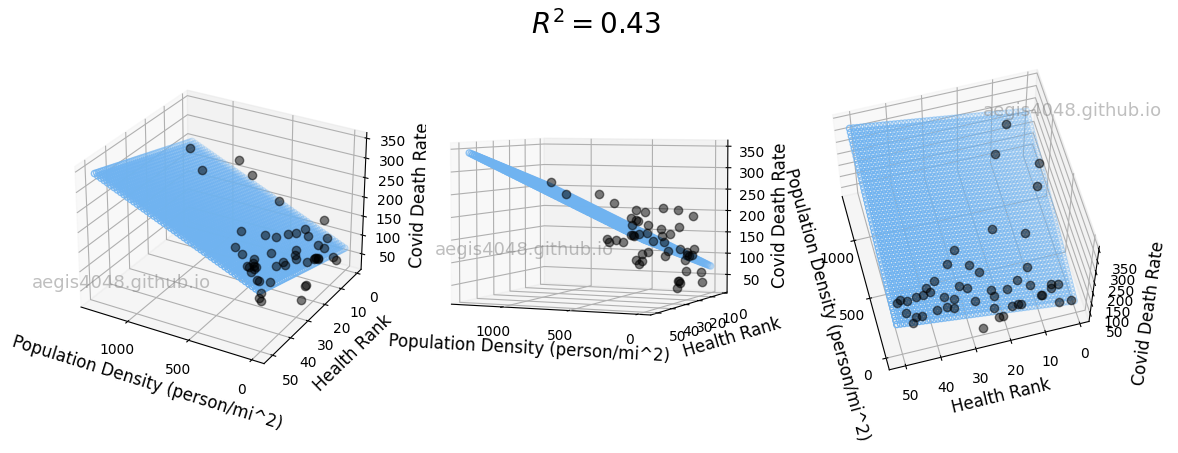

In [273]:
## Population Density + Health Rank
X = controlled_corr.dropna()[['population_density', 'health_rank']].values.reshape(-1,2)
Y = controlled_corr.dropna()['deaths_per_100k'].dropna().values
######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(0, 1300, 50)   # range of population_density values
y_pred = np.linspace(1, 51, 50)  # range of health_rank values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Population Density (person/mi^2)', fontsize=12)
    ax.set_ylabel('Health Rank', fontsize=12)
    ax.set_zlabel('Covid Death Rate', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

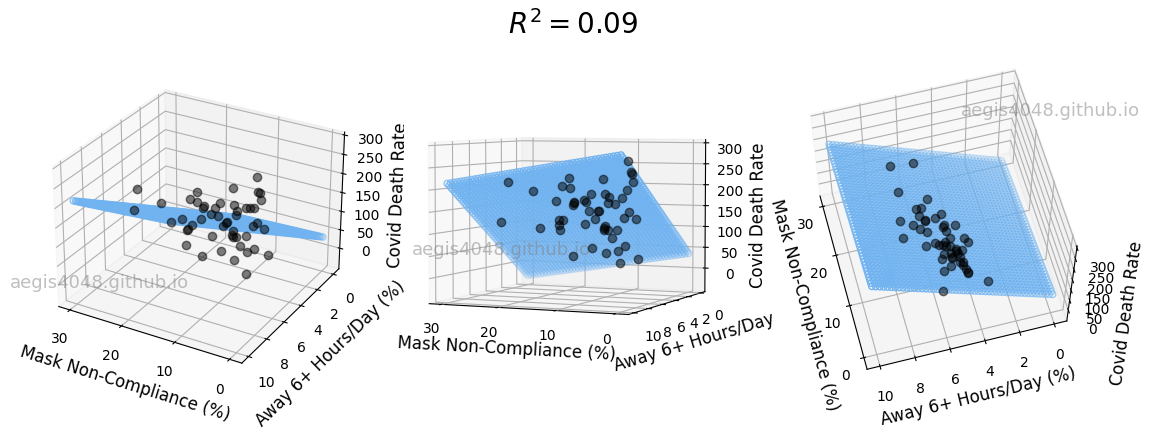

In [274]:
## Mask Non-Compliance + Away 6+ Hours
X = controlled_corr.dropna()[['mask_non_compliance_rate', 'away_6_plus']].values.reshape(-1,2)
X[:,1] *= 100
Y = controlled_corr.dropna()['deaths_per_100k'].dropna().values
######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(0, 30, 50)   # range of mask_non_compliance_rate values
y_pred = np.linspace(0, 10, 50)  # range of away_6_plus values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Mask Non-Compliance (%)', fontsize=12)
    ax.set_ylabel('Away 6+ Hours/Day (%)', fontsize=12)
    ax.set_zlabel('Covid Death Rate', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

In [275]:
# Population Density + Health Rank + Type 2 Diabetes Rate
X = controlled_corr.dropna()[['population_density', 'health_rank', 'type_2_diabetes_rate']]
Y = controlled_corr.dropna()['deaths_per_100k']

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

print("Population Density + Health Rank + Type 2 Diabetes Rate r2: {}".format(r2))

Population Density + Health Rank + Type 2 Diabetes Rate r2: 0.43553368568440165


In [276]:
# NPI model
X = controlled_corr.dropna()[['mask_non_compliance_rate', 'away_6_plus', 'spending_time_with_others_outside_home']]
Y = controlled_corr.dropna()['deaths_per_100k']

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)

############################################## Evaluate ############################################

r2 = model.score(X, Y)

print("Mask Non-Compliance + Away 6+ Hours/day + Spending Time with Others r2: {}".format(r2))

Mask Non-Compliance + Away 6+ Hours/day + Spending Time with Others r2: 0.08718601926046543
